In [6]:
# type: ignore
from dataclasses import dataclass
from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
import pytest
import os

import hermes

np.random.seed(42)
tf.random.set_seed(42)

SIM_LOAD_DIR = Path("").absolute().joinpath("resources")
WAFER_COORDS_FILE = "XY_Coordinates_177.txt"
WAFER_COMPOSITION_FILE = "CombiView_Format_GeSbTe_Composition.txt"
WAFER_XRD_FILE = (
    "GeSbTe_XRD_MetaStable_Background subtracted and with normalization.txt"
)

instrument = hermes.instruments.CHESSQM2Beamline(
    simulation=True,
    wafer_directory=SIM_LOAD_DIR,
    wafer_coords_file=WAFER_COORDS_FILE,
    wafer_composition_file=WAFER_COMPOSITION_FILE,
    wafer_xrd_file=WAFER_XRD_FILE,
    sample_name="This is a great name",
)

In [7]:
@dataclass
class RandomStart:
    domain: np.ndarray
    start_measurements: int

    def initialize(self):
        indexes = np.arange(0, self.domain.shape[0])
        permute = np.random.permutation(indexes)

        next_indexes = permute[0 : self.start_measurements]

        return next_indexes

In [8]:

domain_2d = instrument.composition_domain_2d
domain_3d = instrument.composition_domain[1]
start_measurements = 11
initialization_method = RandomStart(instrument.composition_domain_2d, start_measurements)
next_indexes = initialization_method.initialize()
next_locations = domain_2d[next_indexes]
domain = instrument.xy_locations.to_numpy()
# Get the indexes in the domain:
indexes = np.arange(0, domain.shape[0])

# Initialize containers for locations and measurements:
locations = np.array([]).reshape(-1, domain_2d.shape[1])
measurements = np.array([]).reshape(-1, instrument.sim_two_theta_space.shape[0])
next_measurements = instrument.move_and_measure(domain_3d[next_indexes])

locations = np.append(locations, next_locations, axis=0)
measurements = np.append(measurements, next_measurements, axis=0)

cluster_method = hermes.clustering.RBPots(
    measurements=measurements,
    measurements_distance_type=hermes.distance.CosineDistance(),
    measurements_similarity_type=hermes.similarity.SquaredExponential(lengthscale=0.1),
    locations=locations,
    resolution=0.2,
)
# cluster_method.form_graph()
cluster_method.cluster()
cluster_method.get_local_membership_prob()

# TODO use qm2 example

classification_method = hermes.classification.HeteroscedasticGPC(
    locations=locations,
    labels=cluster_method.labels,
    domain=domain,
    probabilities=cluster_method.probabilities,
    measured_indexes=indexes,
    indexes=indexes,
)

In [9]:
cluster_method.labels

array([2, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1])

In [10]:
classification_method.train()

In [11]:
classification_method.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17908
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[-0.37781, -0.22536, 0.60355..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[4.0220e-01, 0.0000e+00, 0.0000e+00..."


In [12]:
classification_method.predict()

In [13]:
classification_method.mean.shape

TensorShape([177, 3])

In [14]:
classification_method.model.predict_y

<bound method GPModel.predict_y of <gpflow.models.vgp.VGP object at 0x7fd1fd948e50>>

In [15]:
import tensorflow as tf
from typing import List, Optional, Tuple, Union, Callable

In [16]:
hasattr(classification_method.model, "compiled_predict_f")

False

In [17]:
domain.shape

(177, 2)

In [48]:
from typing import Any

In [57]:
# from https://gpflow.github.io/GPflow/2.9.0/notebooks/getting_started/saving_and_loading.html#TensorFlow-saved_model
classification_method.model.compiled_predict_f = tf.function(
    lambda Xnew: classification_method.model.predict_f(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None,domain.shape[1]], dtype=tf.float64)],
)
classification_method.model.compiled_predict_y = tf.function(
    lambda Xnew: classification_method.model.predict_y(Xnew, full_cov=False),
    input_signature=[tf.TensorSpec(shape=[None,domain.shape[1]], dtype=tf.float64)],
)

In [58]:
tf.saved_model.save(classification_method.model, "saved_model_test_1")

INFO:tensorflow:Assets written to: saved_model_test_1/assets


INFO:tensorflow:Assets written to: saved_model_test_1/assets


In [59]:
load_test = tf.saved_model.load("saved_model_test_1")

In [55]:
load_test.compiled_predict_y

In [22]:
classification_method.model.predict_y

<bound method GPModel.predict_y of <gpflow.models.vgp.VGP object at 0x7fd1fd948e50>>

In [23]:
mean1, var1 = classification_method.model.predict_y(domain)

In [24]:
mean1

<tf.Tensor: shape=(177, 3), dtype=float64, numpy=
array([[0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
     

In [42]:
from matplotlib import pyplot as plt

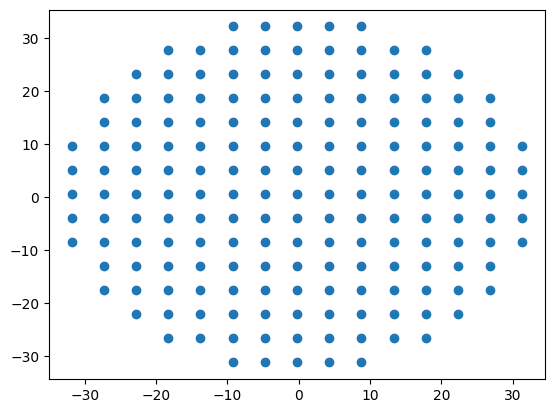

In [44]:
plt.scatter(domain[:,0], domain[:,1])

In [46]:
classification_method.predict()

In [45]:
classification_method.model

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,119.8443
VGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.17202
VGP.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.001
VGP.num_data,Parameter,Identity,,False,(),int32,11
VGP.q_mu,Parameter,Identity,,True,"(11, 3)",float64,"[[0.13433, 0.50222, -0.63631..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(3, 11, 11)",float64,"[[[1.5559e-01, 0.0000e+00, 0.0000e+00..."


In [46]:
mean1, var1 = classification_method.model.predict_y(s)

In [47]:
mean1

<tf.Tensor: shape=(177, 3), dtype=float64, numpy=
array([[0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [0.33333301, 0.33333301, 0.33333301],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
       [       nan,        nan,        nan],
     

In [42]:
c = np.zeros((172,2))*np.NaN
n = domain[0:5,:]
s = np.concatenate((n,c), axis=0)

In [60]:
mean2, var2 = load_test.compiled_predict_y(n)

In [64]:
load_test.kernel

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7fd1f5e83460>

In [36]:
np.sum(mean1 != mean2)

531

In [37]:
np.sum(mean1 == mean2)

0